План лекции (временный блок):
* GAN - Генеративно-состязательная сеть (англ. Generative adversarial network, сокращённо GAN)
 * Контент: изображения архитектуры сети
 * Контент: Генератор (архитектура)
 * Контент: Классификатор (архитектура)
* cGAN - Условные порождающие состязательные сети CGAN (Conditional Generative Adversarial Nets)
 * Картинка принципа работы (в сеть подаются так же изображения)
 * like above: арихитектура cGAN
* DCGAN (Deep Convolutional Generative Adversarial Nets)
 * де-факто это cGAN, только для изображений, картинки похожи
* StackGAN - порождающая состязательная сеть для генерации фото-реалистичных изображений исходя из текстового описания
* LAPGAN (Laplacian Pyramid of Adversarial Networks)
* ControlGAN (Controllable Generative Adversarial Networks)
* AC-GAN Auxiliary Classifier Generative Adversarial Networks

# Блок с мусором

## Ниже - лекция Техносферы

https://www.youtube.com/watch?v=hPux6TVtM58%D0%BF

#### План лекции
1. Обучение без учителя и GAN
2. Применения GAN
* DCGAN
* Domain transfer network
* SRGAN
* Text to image (StackedGAN)
* Image to image (cGAN)
3. Проблема плохих градиентов и подходы к решению
* LSGAN
* WGAN
* BEGAN

### Генерация при размеченном датасете

Пусть у нас

#### Learning to generate Chairs, Tables and Cars

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-06.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-07.png" width="300">

**Почему получилось так удачно?** 

*Огромное количество информации на входе*


1. категория семпла
2. углы и повороты
3. заданные параметры трансформаций
4. сегментация

**Можно ли автоматизировать извлечение этих фичей?**

# Генеративно-состязательные нейронные сети

## Введение

Когда мы изучаем окружающий мир, то у нас нет ответов что есть что, однако, со временем, мы учимся распознавать образы, речь, движения благодаря тому, что мы просто смотрим и слушаем! Если детям сказать "Это собака" - это ничтожно маленькая информация. 

Положим, если давать человеку бит в секунду, и, учитывая что человек живёт в среднем $10^9$ секунд, а так же то, что в мозге человека примерно $10^{14}$ нейронных связей, значит человек использует мозг на одну стотысячную. Откуда ему получить столько информации чтобы стать человеком? Изучать мир самому! Анализируя все входные источники своего тела: глаза, уши и так далее.

Метки, к которым мы привыкли в курсе нейронных сетей, в изображении с глаз отсутствуют. То есть преимущественно мы учимся без учителя.

Как подойти к такой задаче с помощью нейронных сетей?

## Поставим задачу генерации.

Мы имеем неразмеченные данные, и хотим генерировать новые данные, которые будут удовлетворять следующим условиям:
* Новые данные должны быть похожи на исходные
* При этом не повторять их в точности (или повторять, при случайном стечении обстоятельств)

### Эволюция в генерации изображений лиц:

<img src="face_evol.jpg" alt="alttext" style="width: 700px;"/>

**https://thispersondoesnotexist.com**

## Latent space

Поскольку мы обусловились о случайности, то нам эту случайность нужно реализовать. Как это сделать с нейронной сетью? В сетях, которые мы проходили при подаче экземпляра и фиксированных весах всегда получается один и тот же результат. Случайно изменять веса сети? Есть способ лучше - давать в качестве входа случайных шум.

![random_example.png](random_example.png)

Почему именно вектор? Почему не одно случайное число. Ответ прост: изменяя одно случайное число, мы будем перемещаться на очень небольшое расстояние и генерация будет однообразной. Поскольку мы физически не можем генерировать числа в бесконечных пределах, мы вынуждены использовать фиксированный диапазон.

В одномерном случае, взяв диапазон [0,1] у нас всего одна размерность нашего перемещения.
Если взять двухмерный, или трёхмерный случай, то у нас уже есть две и три **степени свободы**.

То есть случайный шум большой размерности даёт нам больше объёма для генерации. Это называется **input latent space** - входное латентное простанство.

Note: из-за неустоявшейся терминологии, случайное распределение на входе генератора называется латентным пространством, так же как и скрытое пространство в автоэнкодерах. Поэтому в этой лекции будем называть его **входным** латентным пространством. Так же встречается вариант: predefined latent space.

#### Какую размерность и форму выбрать?

Длина вектора (размерность латентного пространства) выбирается больше, чем количество разных
независимых свойств объекта, которые мы хотим получить. Если длина 0, то случайности
нет и генератор будет всегда производить один и тот же объект. Если длина 1, то будет
шкала, вдоль которой будут расположены, например, генерируемые изображения. Для генератора
лиц, это будет, в лучшем случае, шкала от молодой женщины блондинки к пожилому мужчине
брюнету. Лучший способ выбрать длину вектора - это посмотреть похожую задачу в публикациях,
взять подобную размерность, и начать экспериментировать с размерностью оттуда.

У большого латентного пространства есть минусы: увеличивая размерность латентного пространства мы можем расширить его настолько, что при обучении модели точек в этом латентром пространстве будет настолько мало, что в основном пространство будет состоять из пустот. Тогда модель будет крайне некачественно "понимать" что ей нужно генерировать в точке, которой не было на обучающей выборке.

Аналогичный вопрос встаёт и по поводу формы распределения входного латентного пространства. Как мы знаем из лекции про обучение сети, инициализация весов и нормализация имеют существенный вклад в работу модели. Поэтому, принято использовать многомерное нормальное распределение для input latent space, потому что оно лучше взаимодействует с весами модели и увеличивает сходимость.

![](MultivariateNormal.png)

## Попробуем решить эту задачу полносвязной сетью

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

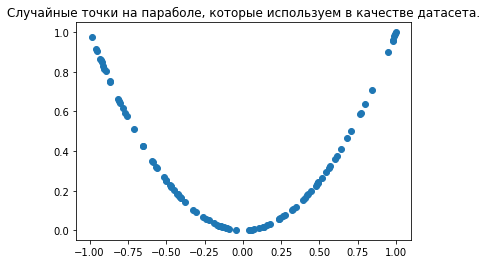

In [12]:
def gen_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x*x
    return np.hstack((x.reshape(-1,1), y.reshape(-1,1)))

pairs = gen_pair(100)
plt.scatter(pairs[:,0], pairs[:,1])
plt.title("Случайные точки на параболе, которые используем в качестве датасета.")
plt.show()

В этом, простом случае, латентным пространством уна

In [18]:
n_batches = 10
batch_size = 4096
ls = 3 # latent space

noice = np.random.normal(size=(n_batches*batch_size, ls))
noice = torch.tensor(noice, dtype=torch.float)
print(f"noice.shape: {noice.shape}")

xy_pair = gen_pair(num = n_batches*batch_size)
xy_pair = torch.tensor(xy_pair, dtype=torch.float)
print(f"xy_pair.shape: {xy_pair.shape}")

dataset = TensorDataset(noice, xy_pair) # model inputs, model outputs

len_tr = int(len(dataset)*0.8)
len_tst = len(dataset) - len_tr
trainset, testset = random_split(dataset,[len_tr,len_tst])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

noice.shape: torch.Size([40960, 3])
xy_pair.shape: torch.Size([40960, 2])


In [22]:
# latent_space=3
# for x,y in train_loader:
#     print(x.shape)
#     print(y.shape)
#     x = x.view(-1, latent_space)
#     print(x.shape)
#     break


In [ ]:
def get_test_loss(model,testloader,loss_function, device="cuda"):
    with torch.no_grad():
        loss_test_total = 0
        for samples, labels in testloader:
            outputs = model(samples.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss_test_total += loss.item()
        return loss_test_total/len(testloader)

In [23]:
class NotWorkModel(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.latent_space = latent_space
        self.fc1 = nn.Linear(latent_space, 25)
        self.fc2 = nn.Linear(latent_space, 25)
        self.fc3 = nn.Linear(25,2)

    def forward(self, x):
        # x = x.view(-1, latent_space)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
epochs = 10
model = NotWorkModel(latent_space = ls)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()


for epoch in range(epochs):
    loss_epoch = 0
    for samples, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(samples)
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        self.optimizer.step()
        loss_epoch += loss.item()
        
    loss_test = get_test_loss(model,testloader,loss_function, device="cpu")
        
    print(f"Epoch={epoch+1} train_loss={loss_epoch/len(trainloader):.4} test_loss={loss_test:.4}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x25 and 3x25)

# Как определить лосс функцию "похожести" изображения?

#### Автоэнкодеры

Идея очень похожая на PCA: найти сжимающее отображение исходных данных (Encoder) в пространство меньшей размерности, такое, что из него возможно восстановить исходное изображение (Decoder).

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-08.png" width="700">

#### Наивный подход

Естественно, хочется взять MSE как лосс-функцию и попробовать оптимизировать.

Но, к сожалению, результаты **не впечатляют.**

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-09.png" width="700">

Возможно, мы взяли слишком простой лосс, можно придумать что-то лучше?

#### Глубокое распознавание

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-10.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-11.png" width="700">

#### Вопросы

* Как глубина влияет на степень реконструкции? (текстура, цвет, положение)
* Каков эффект max-pooling?
* Как можно использовать готовые классификаторы?

#### Эмпирические результаты

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-13.png" width="700">

#### На практике

Действительно работает, настроить параметры несложно.

* Лучше всего использовать комбинацию loss-функций
* Image-to-image loss: L1
* Deep features loss: VGG 16/19
* Регуляризация: total variation

**Но можно еще лучше!**

#### Генеративные состязательные сети (GAN)

Введем основные определения:
$z ∼ p_z(z)$ - noise vector
$p_g(z)$ - распределение сгенерированных картинок из noise
$p_{data}(x)$ - распределение настоящих картинок
$G(z)$ - генератор (генерирует картинку из z)
$D(x)$ - дискриминатор (отличает реальные от сгенерированных)

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-15.png" width="700">

Задача генератора - сгенерировать картинку, которую дискриминатор сочтет реалистичной.

Задача дискриминатора - отличить сгенерированную от реальной.


Математически - это игра двух игроков:

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-16.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-17.png" width="700">

#### Теоретические результаты

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-18.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-19.png" width="700">

#### Training algorithm

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-20.png" width="700">

#### Takeaway

**Преимущества GAN**
* Теоретические гарантии сходимости
* Можно обучать обычным SGD
* Решает в явном виде задачу generative modeling
* Но неявным образом (нейросети)


**Недостатки GAN**
* Нестабильное обучение
* Очень долгая сходимость
* Mode-collapsing
* Generator/Discriminator starvation
* Поиск оптимальных параметров - pure luck

**Тем не менее, на практике GAN почти всегда дает заметные улучшения. Следующая лекция о том, как улучшить GAN.**

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-22.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-23.gif" width="700">

#### DCGAN

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Auxiliary Classifier GAN, или AC-GAN для краткости, является расширением GAN, который изменяет дискриминатор, чтобы предсказать метку класса данного изображения, а не получить его в качестве входных данных. 

Он имеет эффект стабилизации процесса обучения и позволяет генерировать большие высококачественные изображения, изучая представление в скрытом пространстве, которое не зависит от метки класса.


<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-51.png" width="400">

Был предложен новый метод улучшения обучения выигрышей путем кондиционирования входных данных метками классов.

Multi-input multi-output network:
* Входные данные: встраивание класса и вектор шума
* Выходы: двоичный классификатор (поддельные/реальные изображения) и многоклассовый классификатор (классы изображений)

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-57.png" width="400">

Реализация:
* Generator
* Discriminator
* dual loss functions

Архитектура описана таким образом, что дискриминатор и вспомогательный классификатор могут рассматриваться как отдельные модели, разделяющие веса моделей. На практике дискриминатор и вспомогательный классификатор могут быть реализованы в виде единой нейросетевой модели с двумя выходами.

Первый вывод представляет собой единственную вероятность через сигмоидную функцию активации, которая указывает на “реальность” входного изображения и оптимизируется с использованием двоичной перекрестной энтропии, как обычная модель дискриминатора GAN.

Второй вывод-это вероятность принадлежности изображения к каждому классу через функцию активации softmax, как и любая заданная многоклассовая классификационная нейросетевая модель, и оптимизируется с использованием категориальной кросс-энтропии.

**Generator Model:**
* Input: Random point from the latent space, and the class label.
* Output: Generated image.

**Discriminator Model:**
* Input: Image.
* Output: Probability that the provided image is real, probability of the image belonging to each known class.

На приведенном ниже графике суммируются входные и выходные данные ряда условных грантов, включая AC-GAIN, обеспечивая некоторый контекст для различий.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-56.png" width="400">

DCGAN использует сверточные и сверточно-транспонированные (convolutional and convolutional-transpose) слои в дискриминаторе и генераторе соответственно. 

Впервые он был описан Рэдфордом и др. в статье "Обучение неконтролируемому представлению с помощью Глубоких Сверточных генеративных состязательных сетей". Дискриминатор состоит из чередующихся слоев свертки, слоев пакетной нормы и активаций LeakyReLU. 

**input ** - это входное изображение размером 3x64x64, а output -скалярная вероятность того, что вход получен из реального распределения данных.** 

Генератор состоит из сверточно-транспонированных слоев, слоев пакетной нормы и активаций ReLU. Входным сигналом является скрытый вектор z, который берется из стандартного нормального распределения, а выходным-изображение RGB размером 3x64x64.

Шаговые конвективные слои позволяют латентному вектору трансформироваться в объем той же формы, что и изображение.

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-24.png" width="700">

#### Результаты

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-25.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-50.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-49.png" width="700">

#### Интерполяция

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-26.png" width="700">

#### Domain transfer network

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-27.png" width="700">

#### Результаты

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-28.png" width="700">

#### Super resolution GAN

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-29.png" width="700">

### SRGAN

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-30.png" width="700">

### Text to image

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-31.png" width="700">

#### Модель 

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-32.png" width="700">

#### Алгоритм

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-33.png" width="700">

### Image to image

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-34.png" width="700">

#### Модель

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-35.png" width="700">

#### Алгоритм

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-36.png" width="700">

### Иллюстрации

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-37.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-38.png" width="700">

#### Проблемы

**Visual**
* Mode-collapsing
* Instability (long run)
* Noise generation (L1 лучше по началу)
* Bad converging (подбор гиперпараметров - боль)


**Возможно, проблема в том, что мы оптимизируем что-то не то?**

#### LSGAN

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-40.png" width="700">

#### Модель

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-41.png" width="700">

#### Результат

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-42.png" width="700">

#### Проблема

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-43.png" width="700">

#### Расстояние Вассерштейна

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-44.png" width="700">

#### Wasserstein > KL

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-45.png" width="700">

#### Обучение 

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-46.png" width="700">

#### СХОДИМОСТЬ

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-47.png" width="700">

<img src ="http://edunet.kea.su/repo/src/L13_GAN_cGAN/img/11-48.png" width="400">

## Ссылки

## StackGAN

https://medium.com/@rangerscience/lets-read-science-stackgan-text-to-photo-realistic-image-synthesis-4562b2b14059

https://arxiv.org/pdf/1612.03242v2.pdf

https://arxiv.org/pdf/1710.10916.pdf

https://www.rulit.me/data/programs/resources/pdf/Generative-Adversarial-Networks-with-Python_RuLit_Me_610886.pdf

видео

https://www.youtube.com/watch?v=PXWIaLE7_NU

https://www.youtube.com/watch?v=crI5K4RCZws

гит

https://github.com/zeusm9/Text-to-Photo-realistic-Image-Synthesis-with-Stacked-Generative-Adversarial-Networks

## LAPGAN (Laplacian Pyramid of Adversarial Networks)

https://arxiv.org/pdf/1506.05751.pdf

https://paperswithcode.com/method/lapgan

https://sh-tsang.medium.com/review-lapgan-laplacian-generative-adversarial-network-gan-e87200bbd827



## ControlGAN

https://github.com/mrlibw/ControlGAN

https://github.com/taki0112/ControlGAN-Tensorflow

статьи

https://arxiv.org/pdf/1708.00598.pdf

https://arxiv.org/pdf/1909.07083.pdf

https://arxiv.org/pdf/1910.05774.pdf  многабукв

https://meta-guide.com/data/data-processing/text-to-image-systems/natural-language-text-to-image-2019 множественные ссылки 

## AC-GAN Auxiliary Classifier Generative Adversarial Networks

статьи

https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/ можно брать материал
https://towardsdatascience.com/understanding-acgans-with-code-pytorch-2de35e05d3e4

https://arxiv.org/pdf/1909.05370.pdf

https://openaccess.thecvf.com/content/WACV2021/papers/Kavalerov_A_Multi-Class_Hinge_Loss_for_Conditional_GANs_WACV_2021_paper.pdf

гит

https://github.com/lukedeo/keras-acgan